# Import libraries

In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

# Define constants

In [2]:
c = 299792.458
H0 = 75
f0 = 6.61* 10**-9 * 10**(-7) * (3.2408*10**(-25))**(-2)
megaparsec = 3.0856775814913673 * 10**10

# Some key functions

In [3]:
def scale_factor(z):
    return 1/(1+z)

#for nearby SN

def co_moving_dist_near(z):
    return c*z/H0

def mag_model_near(z, Lpl):
    rc = co_moving_dist_near(z)
    flux = Lpl/(4*np.pi*((1+z)**2)*((rc)**2))
    argument = flux/f0
    mag = -2.5*np.log10(argument)
    return mag

#for far away SN
def Friedmann_eq(z, omega_DE):
    omega_M = 1 - omega_DE
    a = scale_factor(z)
    return H0*np.sqrt(omega_M/(a**3) + omega_DE + (1-omega_M-omega_DE)/(a**2))

def integrand(z, omega_DE):
    return c/Friedmann_eq(z, omega_DE)

def co_moving_dist(z_up, omega_DE):
    dist, err = scp.integrate.quad(integrand, 0, z_up, args = (omega_DE))
    return dist

def mag_model(z, omega_DE):
    rc = co_moving_dist(z, omega_DE)
    flux = LPeakLambda/(4*np.pi*(rc**2)*((1+z)**2))
    argument = flux/f0
    mag = -2.5*np.log10(argument)
    return mag

# Load the data

In [4]:
sn_z_near, sn_mag_near, sn_mag_err_near =  np.loadtxt("sn_data_nearby.txt", unpack = True, usecols=(1,2,3))
sn_z_far, sn_mag_far, sn_mag_err_far =  np.loadtxt("sn_data_distant.txt", usecols=(1,2,3), unpack = True)
sn_z, sn_mag, sn_mag_err = np.loadtxt("sn_data.txt", usecols=(1,2,3), unpack = True)



# Chi squared mininimisation to find peak luminosity

minimum chi-squared value is 21.455580998801018, and occurs at a peak luminosity of 1.434954954954955e+36 + 6.342342342342332e+34 - 6.078078078078086e+34 for 18 degrees of freedom
3736861861.8618617


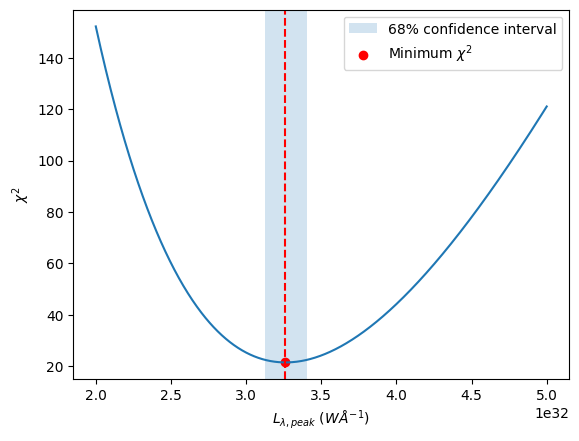

In [5]:
trial_Lpl_vals = np.linspace(2*10**32,5*10**32,1000)
#print(trial_DE_vals)
DoF = sn_z_near.size
chisquared_vals = np.zeros(len(trial_Lpl_vals))
i1 = 0
for trial_Lpl in trial_Lpl_vals:
    #print(f"\ntrial value: {trial_DE}")
    for i2 in range(len(sn_z_near)):
        redshift = sn_z_near[i2]
        mag_predicted = mag_model_near(redshift, trial_Lpl)
        mag_actual = sn_mag_near[i2]
        mag_actual_err = sn_mag_err_near[i2]
        sq_norm_resid = ((mag_predicted-mag_actual)/mag_actual_err)**2
        chisquared_vals[i1] += sq_norm_resid
        #print(f"redshift: {redshift}, mag_pred: {mag_predicted}, mag_act: {mag_actual}, chisq: {sq_norm_resid}, tally: {chisquared_vals[i1]}")
    i1 += 1
#print(chisquared_vals)
index_min_chisq = np.argmin(chisquared_vals)
min_chisq_val = chisquared_vals[index_min_chisq]
optimised_Lpl = trial_Lpl_vals[index_min_chisq]
LPeakLambda = optimised_Lpl
greaterchisq = chisquared_vals[index_min_chisq:]
lowerchisq = chisquared_vals[:index_min_chisq]
lower_err_index = len(lowerchisq[lowerchisq>=(min_chisq_val+1)]) - 1
upper_err_index = np.argmax(greaterchisq>=min_chisq_val+1) + index_min_chisq
Llower_bound = trial_Lpl_vals[lower_err_index]
Lupper_bound = trial_Lpl_vals[upper_err_index]
central_wavelength = 0.44 * (10**(-6)) * (10**10)
optimisedLPeak = optimised_Lpl * central_wavelength
print(f"minimum chi-squared value is {min_chisq_val}, and occurs at a peak luminosity of {optimisedLPeak} + {central_wavelength*(Lupper_bound-optimised_Lpl)} - {central_wavelength*(optimised_Lpl-Llower_bound)} for {DoF} degrees of freedom")
print(optimisedLPeak/(3.84*10**26))
plt.figure()
plt.plot(trial_Lpl_vals, chisquared_vals)
plt.axvspan(Llower_bound, Lupper_bound, alpha = 0.2, label = "68% confidence interval")
plt.scatter(optimised_Lpl, min_chisq_val, label = "Minimum ${χ^{2}}$", color = "red")
plt.axvline(optimised_Lpl, 0, color = "red", linestyle = "--")
plt.ylabel("${χ^{2}}$")
plt.xlabel("${L_{λ, peak}}$ ${(W Å^{-1})}$")
plt.legend()
plt.savefig("chisq-plot-L-peak-Lambda.png", bbox_inches = "tight")
plt.show()

Peak luminosity per wavelength interval is then (3.26 +/- 0.14) x ${10^{32}}$ ${W Å^{-1}}$

# Plotting mag-redshift data for nearby SNIa

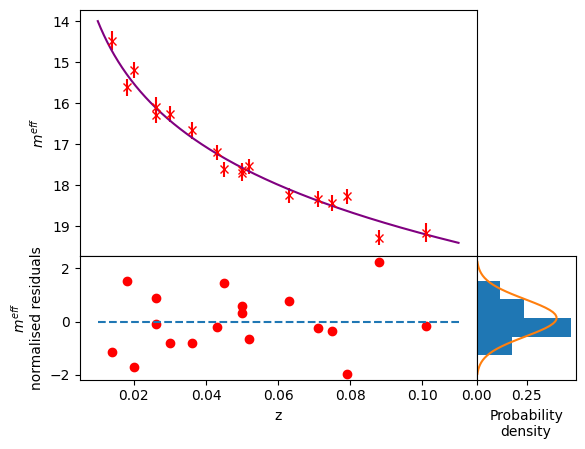

In [6]:
def zero_funct(x):
    return 0*x
trial_z_near = np.linspace(0.01, 0.11, 1000)
trial_mag_near = mag_model_near(trial_z_near, LPeakLambda)
trial_mag_near_lower = mag_model_near(trial_z_near, Llower_bound)
trial_mag_near_upper = mag_model_near(trial_z_near, Lupper_bound)

norm_resid = (sn_mag_near - mag_model_near(sn_z_near, LPeakLambda))/sn_mag_err_near
fig, axs = plt.subplots(2, 2, width_ratios=[4,1], height_ratios=[2,1])
axs[0,0].errorbar(sn_z_near, sn_mag_near, yerr=sn_mag_err_near, marker = "x", linestyle = 'None', color = "red")
axs[0,0].plot(trial_z_near, trial_mag_near, color = "purple")
#axs[0,0].fill_between(trial_z, trial_mag_lower, trial_mag_upper, color = "purple", alpha = 0.2)
#axs[0].errorbar(sn_z_far, sn_mag_far, yerr=sn_mag_err_far, marker = "x", linestyle = 'None', color = "blue", label = "distant SN")
axs[1,0].scatter(sn_z_near, norm_resid, color = "red")
axs[1,0].plot(trial_z_near, zero_funct(trial_z_near), linestyle = "dashed")
axs[1,0].set_xlabel("z")
axs[0,0].set_ylabel("${m^{eff}}$")
axs[1,0].set_ylabel("${m^{eff}}$\nnormalised residuals")
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
#axs[0].legend()
axs[0,0].invert_yaxis()
axs[0,1].remove()
axs[1,1].get_yaxis().set_visible(False)
axs[1,1].hist(norm_resid, density = True, orientation = u'horizontal', bins = range(-3,3))
xs = np.linspace(-3,3)
axs[1,1].plot(scp.stats.norm.pdf(xs, 0, 1), xs)
axs[1,1].set_xlabel("Probability\ndensity")
plt.savefig("effMagNearby-redshift-normResid-graph", bbox_inches = "tight")
plt.show()

# Finding energy densities: distant SN only

minimum chi-squared value is 81.32990354369136, and occurs at a dark energy density of 0.7122712271227123 + 0.046904690469046884 - 0.04950495049504955 for 42 degrees of freedom and a reduced chi-sq value of 1.9364262748497942


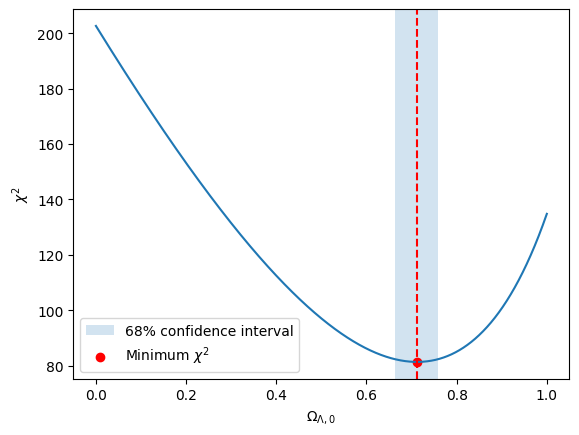

In [10]:
trial_DE_vals = np.linspace(0,1,10000)
#print(trial_DE_vals)
DoF = sn_z_far.size
chisquared_vals = np.zeros(len(trial_DE_vals))
i1 = 0
for trial_DE in trial_DE_vals:
    #print(f"\ntrial value: {trial_DE}")
    for i2 in range(len(sn_z_far)):
        redshift = sn_z_far[i2]
        mag_predicted = mag_model(redshift, trial_DE)
        mag_actual = sn_mag_far[i2]
        mag_actual_err = sn_mag_err_far[i2]
        sq_norm_resid = ((mag_predicted - mag_actual)/mag_actual_err)**2
        chisquared_vals[i1] += sq_norm_resid
        #print(f"redshift: {redshift}, mag_pred: {mag_predicted}, mag_act: {mag_actual}, chisq: {sq_norm_resid}, tally: {chisquared_vals[i1]}")
    i1 += 1
#print(chisquared_vals)
index_min_chisq = np.argmin(chisquared_vals)
min_chisq_val = chisquared_vals[index_min_chisq]
optimised_DE = trial_DE_vals[index_min_chisq]
greaterchisq = chisquared_vals[index_min_chisq:]
lowerchisq = chisquared_vals[:index_min_chisq]
lower_err_index = len(lowerchisq[lowerchisq>=(min_chisq_val+1)]) - 1
upper_err_index = np.argmax(greaterchisq>=min_chisq_val+1) + index_min_chisq
lower_bound = trial_DE_vals[lower_err_index]
upper_bound = trial_DE_vals[upper_err_index]
print(f"minimum chi-squared value is {min_chisq_val}, and occurs at a dark energy density of {optimised_DE} + {upper_bound-optimised_DE} - {optimised_DE-lower_bound} for {DoF} degrees of freedom and a reduced chi-sq value of {min_chisq_val/DoF}")
plt.figure()
plt.plot(trial_DE_vals, chisquared_vals)
plt.axvspan(lower_bound, upper_bound, alpha = 0.2, label = "68% confidence interval")
plt.scatter(optimised_DE, min_chisq_val, label = "Minimum ${χ^{2}}$", color = "red")
plt.axvline(optimised_DE, 0, color = "red", linestyle = "--")
plt.ylabel("${χ^{2}}$")
plt.xlabel("${Ω_{Λ,0}}$")
plt.legend()
plt.savefig("chisq-plot-DE-density-distantSN.png", bbox_inches = "tight")
plt.show()
OmegaLambda = optimised_DE
OmegaLambdaLower = lower_bound
OmegaLambdaUpper = upper_bound



Dark energy energy density is then 0.71 +/- 0.05

# Finding the energy densities: all SN

Minimum chi-squared value is 103.39470816330316, and occurs at a dark energy density of 0.715971597159716 + 0.046404640464046354 - 0.04900490049004902 for 60 degrees of freedom and a reduced chi-sq value of 1.7232451360550527


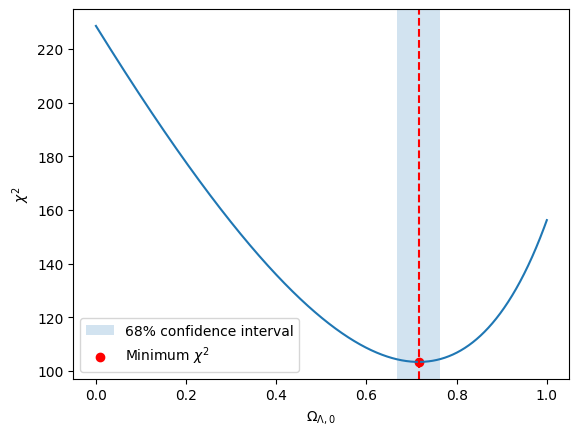

In [8]:
trial_DE_vals = np.linspace(0,1,10000)
#print(trial_DE_vals)
DoF = sn_z.size
chisquared_vals = np.zeros(len(trial_DE_vals))
i1 = 0
for trial_DE in trial_DE_vals:
    #print(f"\ntrial value: {trial_DE}")
    for i2 in range(len(sn_z)):
        redshift = sn_z[i2]
        mag_predicted = mag_model(redshift, trial_DE)
        mag_actual = sn_mag[i2]
        mag_actual_err = sn_mag_err[i2]
        sq_norm_resid = ((mag_predicted - mag_actual)/mag_actual_err)**2
        chisquared_vals[i1] += sq_norm_resid
        #print(f"redshift: {redshift}, mag_pred: {mag_predicted}, mag_act: {mag_actual}, chisq: {sq_norm_resid}, tally: {chisquared_vals[i1]}")
    i1 += 1
#print(chisquared_vals)
index_min_chisq = np.argmin(chisquared_vals)
min_chisq_val = chisquared_vals[index_min_chisq]
optimised_DE2 = trial_DE_vals[index_min_chisq]
greaterchisq = chisquared_vals[index_min_chisq:]
lowerchisq = chisquared_vals[:index_min_chisq]
lower_err_index = len(lowerchisq[lowerchisq>=(min_chisq_val+1)]) - 1
upper_err_index = np.argmax(greaterchisq>=min_chisq_val+1) + index_min_chisq
lower_bound = trial_DE_vals[lower_err_index]
upper_bound = trial_DE_vals[upper_err_index]
#print(greaterchisq)
#print(chisquared_vals)
print(f"Minimum chi-squared value is {min_chisq_val}, and occurs at a dark energy density of {optimised_DE2} + {upper_bound-optimised_DE2} - {optimised_DE2-lower_bound} for {DoF} degrees of freedom and a reduced chi-sq value of {min_chisq_val/DoF}")
plt.figure()
plt.plot(trial_DE_vals, chisquared_vals)
plt.axvspan(lower_bound, upper_bound, alpha = 0.2, label = "68% confidence interval")
plt.scatter(optimised_DE2, min_chisq_val, label = "Minimum ${χ^{2}}$", color = "red")
plt.axvline(optimised_DE2, 0, color = "red", linestyle = "--")
plt.ylabel("${χ^{2}}$")
plt.xlabel("${Ω_{Λ,0}}$")
plt.legend()
plt.savefig("chisq-plot-DE-density-allSN.png", bbox_inches = "tight")
plt.show()



Dark energy energy density is then 0.72 +/- 0.05

# Plotting magnitude-redshift curve for all data

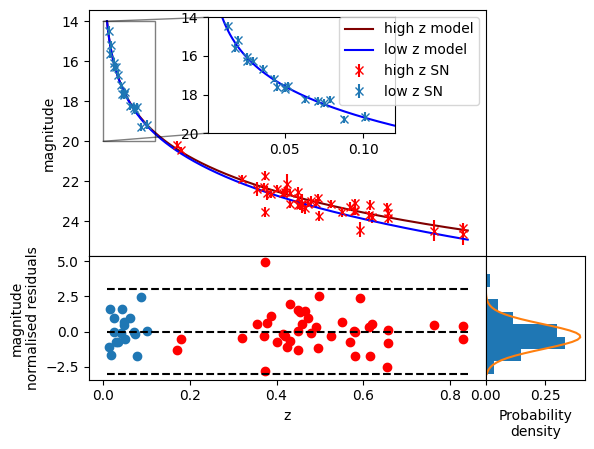

In [9]:
trial_z = np.linspace(0.01, 0.84, 1000)
trial_mag_near = mag_model_near(trial_z, LPeakLambda)
trial_mag = np.zeros(len(trial_z))
trial_mag_lower = np.zeros(len(trial_z))
trial_mag_upper = np.zeros(len(trial_z))
i3 = 0
for trial_redshift in trial_z:
    trial_mag[i3] = mag_model(trial_redshift, OmegaLambda)
    trial_mag_lower[i3] = mag_model(trial_redshift, OmegaLambdaLower)
    trial_mag_upper[i3] = mag_model(trial_redshift, OmegaLambdaUpper)
    i3 += 1
norm_resid_near = np.zeros(len(sn_z_near))
i4 = 0
for trial_redshift2 in sn_z_near:
    norm_resid_near[i4] = (sn_mag_near[i4] - mag_model(trial_redshift2, OmegaLambda))/sn_mag_err_near[i4]
    i4 += 1
norm_resid_far = np.zeros(len(sn_z_far))
i5 = 0
for trial_redshift3 in sn_z_far:
    norm_resid_far[i5] = (sn_mag_far[i5] - mag_model(trial_redshift3, OmegaLambda))/sn_mag_err_far[i5]
    i5 += 1
norm_resid = np.concatenate((norm_resid_near, norm_resid_far))

fig, axs = plt.subplots(2, 2, width_ratios=[4,1], height_ratios=[2,1])
#ax4 = fig.add_subplot()
axs[0,0].plot(trial_z, trial_mag, color = "maroon", label = "high z model")
axs[0,0].errorbar(sn_z_far, sn_mag_far, yerr = sn_mag_err_far, marker = "x", linestyle = "None", color = "red", label = "high z SN")
axs[0,0].plot(trial_z, trial_mag_near, label = "low z model", color = "blue")
axs[0,0].errorbar(sn_z_near, sn_mag_near, yerr=sn_mag_err_near, marker = "x", linestyle = 'None', label = "low z SN")
#axs[0,0].fill_between(trial_z, trial_mag_lower, trial_mag_upper, color = "purple", alpha = 0.75, label = "high z model")
#axs[0].errorbar(sn_z_far, sn_mag_far, yerr=sn_mag_err_far, marker = "x", linestyle = 'None', color = "blue", label = "distant SN")
axs[1,0].scatter(sn_z_near, norm_resid_near)
axs[1,0].scatter(sn_z_far, norm_resid_far, color = "red")
#axs[1,0].hlines(1,0,0.9, linestyle = "--", clip_on = False)
#axs[1,0].hlines(2,0,0.9, linestyle = "--")
axs[1,0].hlines(3,0.01,0.84, linestyle = "--", color = "black")
#axs[1,0].hlines(-1,0,0.9, linestyle = "--")
#axs[1,0].hlines(-2,0,0.9, linestyle = "--")
axs[1,0].hlines(-3,0.01,0.84, linestyle = "--", color = "black")
axs[1,0].hlines(0,0.01,0.84, linestyle = "--", color = "black")
axs[1,0].set_xlabel("z")
axs[0,0].set_ylabel("magnitude")
axs[1,0].set_ylabel("magnitude\nnormalised residuals")
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
axs[0,0].invert_yaxis()
axs[0,1].remove()
axs[1,1].get_yaxis().set_visible(False)
axs[1,1].hist(norm_resid, density = True, orientation = u'horizontal', bins = range(-3,6))
xs = np.linspace(-3,6)
axs[1,1].plot(scp.stats.norm.pdf(xs, 0, 1), xs)
axs[1,1].set_xlabel("Probability\ndensity")
# inset Axes....
z1, z2, m1, m2 = 0.001, 0.12, 14, 20  # subregion of the original image
ax4 = axs[0,0].inset_axes(
    [0.3, 0.5, 0.47, 0.47],
    xlim=(z1, z2), ylim=(m1, m2))
axs[0,0].indicate_inset_zoom(ax4, edgecolor="black")
extent = (0,1,14,26)
ax4.invert_yaxis()
ax4.errorbar(sn_z_near, sn_mag_near, yerr=sn_mag_err_near, marker = "x", linestyle = 'None')
ax4.plot(trial_z, trial_mag_near, color = "blue")
axs[0,0].legend()
#axs[0,0].set_figwidth(1)
plt.savefig("effMagAll-redshift-normResid-graph", bbox_inches = "tight")
plt.show()